# TP3 - Bornes d'Erreur A Posteriori, Méthode d'Échantillonage Glouton

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt

from scipy.sparse import csc_matrix, isspmatrix
from scipy.sparse.linalg import spsolve
from scipy.linalg import cho_factor, cho_solve
from scipy.io import loadmat
from scipy.stats import loguniform
from timeit import timeit
from itertools import product
from IPython.display import Image, display, HTML

np.set_printoptions(precision=5, threshold=9)
pd.set_option("display.precision", 9)


## Partie 1 - Borne inférieure de coercivité et borne d'erreur en norme X

### Q1.

#### (a) Expression explicite de $\alpha_{LB}(\mu)$ pour les cas I et II.

Selon l'approche min-$\theta$, on peut écrire (avec $\bar{\mu} = \{1,1,1,1,1,0.1\}$)

\begin{align*}
    \alpha_{LB}(\mu) &= \alpha(\bar{\mu}) \min_{q=1,\ldots,6}{\frac{\theta^q(\mu)}{\theta^q(\bar{\mu})}} \\
    &= \alpha(\bar{\mu}) \min_{}{ \left\{ \frac{\mu_1}{\bar{\mu_1}}, \, \frac{\mu_2}{\bar{\mu_2}} , \, \frac{\mu_3}{\bar{\mu_3}} , \, \frac{\mu_4}{\bar{\mu_4}} , \, \frac{1}{1} , \, \frac{\mathrm{Bi}}{\bar{\mathrm{Bi}}} \right\} }  \\
    &= \alpha(\bar{\mu}) \min\{k_1, \, k_2, \, k_3, \, k_4, \, 1, \, 10 \!\small\times\! \mathrm{Bi}\}   \\
    &= \alpha(\bar{\mu}) \min\{k, \, 1, \, 10 \!\small\times\! \mathrm{Bi} \}
\end{align*}

D'après la définition de la norme X, nous savons que
\begin{align*}
\alpha(\bar{\mu}) &= \inf_{v \in (X^e)^{^*}}{\frac{a(v, v; \bar{\mu})}{\Vert v \Vert_X^2}} \\
&= \inf_{v \in (X^e)^{^*}}{\frac{\Vert v \Vert_X^2}{\Vert v \Vert_X^2}} \\
&= 1 
\end{align*}

En l'utilisant dans notre formule min-$\theta$, on obtient :
\begin{align*}
\alpha_{LB}(\mu) &= \min\{k, \, 1, \, 10 \!\small\times\! \mathrm{Bi}\} 
\end{align*}

- Cas I : $\alpha_{LB}(\mu) = \min\{k,1\}$ puisque $\mathrm{Bi} = 0.1$
- Cas II : $\alpha_{LB}(\mu) = \min\{k, \, 1, \, 10 \!\small\times\! \mathrm{Bi}\}$

#### (b) Quelle est la plus grande effectivité de la borne d'erreur de la norme d'énergie et de la borne d'erreur de sortie que nous devons prévoir pour le cas I et le cas II ?

En utilisant l'approche max-$\theta$, 
\begin{align*}
\gamma_{UB}(\mu) &= \gamma(\bar{\mu}) \max_{q=1,\ldots,6}{\frac{\theta^q(\mu)}{\theta^q(\bar{\mu})}} \\
&= \gamma(\bar{\mu}) \max{}{\left\{k, \, 1, \, 10 \!\small\times\! \mathrm{Bi} \right\}} 
\end{align*}

Par définition de la norme X, comme ci-dessus, $\gamma(\bar{\mu}) = 1$. Ainsi,

- Cas I : $\gamma_{UB}(\mu) = \max{\left\{ k,1 \right\}}$ puisque $\mathrm{Bi} = 0.1$
- Cas II : $\gamma_{UB}(\mu) = \max{}{\left\{k, \, 1, \, 10 \!\small\times\! \mathrm{Bi} \right\}}$

D'après le cours, l'effectivité (en termes de norme d'énergie) est bornée.
$$
1 \leqslant \eta_N^{en}(\mu) \leqslant \sqrt{\frac{\gamma_{UB}(\mu)}{\alpha_{LB}(\mu)}}
$$

- Cas I:
$$
\begin{align*}
    \eta_N^{en}(\mu) &\leqslant \sqrt{\frac{\max\{k,1\}}{\min\{ k,1 \}}} = 
    \begin{cases}
        \sqrt{k} &\text{si} \quad k\geqslant 1 \\
        \sqrt{\frac{1}{k}} &\text{si} \quad k\leqslant 1
    \end{cases}\\
        &\leqslant \sqrt{10} \qquad \text{car  } k \in [0.1,10]
\end{align*}
$$
- Cas II: 
$$
\begin{align*}
    \eta_N^{en}(\mu) &\leqslant \sqrt{\frac{\max\{ k,1, 10 \!\small\times\! \mathrm{Bi} \}}{\min\{ k,1,10 \!\small\times\! \mathrm{Bi} \}}} \leqslant 
    \begin{cases}
        \sqrt{10} &\text{si } \max\{k,1,10 \!\small\times\! \mathrm{Bi}\} = 1 \text{ ou } \min\{k,1,10 \!\small\times\! \mathrm{Bi}\} = 1 \\
        \sqrt{100} = 10 &\text{sinon}
    \end{cases}\\
        &\leqslant 10 \quad \text{car  } k \in [0.1,10] \text{ et } \mathrm{Bi} \in [0.01,1]
\end{align*}
$$

Les plus grandes effectivités pour la borne de l'erreur de la norme d'énergie pour les cas I et II sont respectivement $\sqrt{10}$ et $10$. 

Pour la borne de l'erreur de sortie, nous avons
$$
1 \leqslant \eta_N^{s}(\mu) \leqslant \frac{\gamma_{UB}(\mu)}{\alpha_{LB}(\mu)}
$$

Les plus grandes effectivités pour la borne de l'erreur de sortie pour les cas I et II sont respectivement de $10$ et $100$.



### Q2.

#### Démontrons les propriétés de la borne d'erreur de la norme X.
$$
1 \leqslant \eta_N(\mu) \leqslant \frac{\gamma_{UB}(\mu)}{\alpha_{LB}(\mu)}   \quad \forall \mu \in \mathcal{D}
$$

*Pour la suite, $\Vert \cdot \Vert$ désigne la norme de X, c'est-à-dire $\Vert \cdot \Vert = \Vert \cdot \Vert_X = \sqrt{(\cdot, \cdot)_X} = \sqrt{a(\cdot, \cdot, \bar{\mu})}$*.

La formule de l'effectivité est
$$
\eta_N(\mu) = \frac{\Delta_N(\mu)}{\Vert e(\mu) \Vert} = \frac{\Delta_N(\mu)}{\Vert u(\mu) - u_N(\mu) \Vert}
$$

* Tout d'abord, calculons une expression pour la borne d'erreur $\Delta_N(\mu)$.  
  Soit le résidu la forme linéaire bornée définie pour tout $v$ dans $X^e$ par
  $$
    r(v; \mu) = a(e(\mu), v, ; \mu)
  $$
  Il existe une représentation de Riesz pour $r$, $\hat{e}(\mu)$, telle que
  $$
    r(v; \mu) = (v, \hat{e}(\mu))_X = a(v, \hat{e}(\mu); \bar{\mu})
  $$
  De plus, 
  $$
    \Vert \hat{e}(\mu) \Vert = \Vert r(\cdot; \mu) \Vert_{X'} = \sup_{v\neq0}{\frac{\Vert r(v; \mu) \Vert }{\Vert v \Vert}} \\
  $$
  c'est-à-dire
  $$
    \Vert r(v; \mu) \Vert \leqslant  \Vert \hat{e}(\mu) \Vert  \Vert v \Vert \quad \forall v \text{ in } X^e
  $$
  En utilisant la coercivité de $a$, on a
  $$
    \alpha_{LB}(\mu) \Vert e(\mu) \Vert^2 \leqslant  a(e(\mu), e(\mu); \mu) = r(e(\mu); \mu) \leqslant \Vert \hat{e}(\mu) \Vert  \Vert e(\mu) \Vert 
  $$
  donc, 
  $$
    \Vert e(\mu) \Vert \leqslant \frac{\Vert \hat{e}(\mu) \Vert }{\alpha_{LB}(\mu)}
  $$
  Un bon choix pour la borne d'erreur est alors
  $$
    \Delta_N(\mu) = \frac{\Vert \hat{e}(\mu) \Vert }{\alpha_{LB}(\mu)}
  $$
  et nous obtenons immédiatement
  $$
    \eta_N(\mu) = \frac{\Delta_N(\mu)}{\Vert e(\mu) \Vert} \geqslant 1
  $$

* En utilisant la continuité de $a$, on a
  $$
    \Vert \hat{e}(\mu) \Vert^2 =  (\hat{e}(\mu), \hat{e}(\mu))_X = r(\hat{e}(\mu); \mu) = a(e(\mu), \hat{e}(\mu); \mu) \leqslant \gamma_{UB} \Vert e(\mu) \Vert \Vert \hat{e}(\mu) \Vert
  $$
  donc, 
  $$
    \Vert \hat{e}(\mu) \Vert \leqslant \gamma_{UB} \Vert e(\mu) \Vert
  $$
  Nous pouvons calculer une borne supérieure de l'effectivité
  \begin{align*}
    \eta_N(\mu) &= \frac{\Delta_N(\mu)}{\Vert e(\mu) \Vert}  \\
      &= \frac{\Vert \hat{e}(\mu) \Vert}{ \alpha_{LB}(\mu) \Vert e(\mu) \Vert }  \\
      &\leqslant  \frac{\gamma_{UB}(\mu) \Vert e(\mu) \Vert}{ \alpha_{LB}(\mu) \Vert e(\mu) \Vert } = \frac{\gamma_{UB}(\mu)}{ \alpha_{LB}(\mu)}   \qquad \text{ en supposant que } \Vert e(\mu) \Vert \neq 0
  \end{align*}

* En conclusion, 
  $$
    1 \leqslant \eta_N(\mu) \leqslant \frac{\gamma_{UB}(\mu)}{\alpha_{LB}(\mu)}   \quad \forall \mu \in \mathcal{D}
  $$


## Chargement des fonctions utiles du TP 2

In [2]:
def loadFEMatrix(tuning):
    M = loadmat('FE_matrix.mat', simplify_cells=True)
    Ahq = M['FE_matrix'][tuning]['Ahq']
    Fh = M['FE_matrix'][tuning]['Fh']
    return Ahq, Fh


def loadSample(sample):
    return loadmat('RB_sample.mat', simplify_cells=True)["RB_sample"][sample]


def buildMu(k=1, Bi=0.1):
    return np.array([k, k, k, k, 1, Bi])


def assembleA(mu, Aq):
    A = mu[0]*Aq[0]
    for k in range(1, 6):
        A += mu[k]*Aq[k]
    return A


def solve(mu, A, F):
    Ah = assembleA(mu, A)
    if isspmatrix(Ah):
        u = spsolve(Ah, F)
    else:
        c, low = cho_factor(Ah)
        u = cho_solve((c, low), F, overwrite_b=False)
    return u

In [3]:
def buildZ(sample, Ahq, Fh, N):
    Ncal = Ahq[0].shape[0]
    Z = np.zeros((Ncal, N))
    cas = len(sample.shape)

    if cas == 2:
        carSample = list(zip(sample[0], sample[1]))
        assert (N <= len(carSample))
    else:
        assert (N <= len(sample))

    for j in range(N):
        if cas == 1:
            k = sample[j]
            mu = buildMu(k)
        if cas == 2:
            k, Bi = carSample[j]
            mu = buildMu(k, Bi)
        u = spsolve(assembleA(mu, Ahq), Fh)
        Z[:, j] = u

    return Z

In [4]:
def inner(u, v, A):
    return u @ A @ v


def norm(u, A):
    return np.sqrt(inner(u, u, A))


def proj(v, u, A):
    return inner(u, v, A) * u / inner(u, u, A)


def orthonormalize(Z, A):
    Z_ = np.zeros_like(Z)
    Z_[:, 0] = Z[:, 0] / norm(Z[:, 0], A)
    N = Z.shape[1]

    for j in range(1, N):
        xj = Z[:, j]
        for k in range(j):
            xj -= proj(Z[:, j], Z_[:, k], A)
        Z_[:, j] = xj / norm(xj, A)

    return Z_


def buildZ_(sample, Ahq, Fh, AhqBar, N):
    Z = buildZ(sample, Ahq, Fh, N)
    return orthonormalize(Z, AhqBar)

In [5]:
def buildOff(Z, Ahq, Fh):  # Construction hors ligne des composants nécessaires
    Anq = np.array([Z.T @ a @ Z for a in Ahq[:6]])

    Fn = Z.T @ Fh
    Ln = Z.T @ Fh

    return Anq, Fn, Ln


def computeAlpha(mu, Ahq, AhqBar):
    Ah = assembleA(mu, Ahq)
    v0 = np.linspace(min(1, mu[0]), 1, Ah.shape[0])
    alpha = sp.sparse.linalg.eigsh(Ah, k=1, M=AhqBar, v0=v0, which='SM', return_eigenvectors=False)[0]
    return alpha

## Partie 2 - Estimation de l'erreur à posteriori

### Q3.

In [6]:
Ahq, Fh = loadFEMatrix("medium")
muBar = buildMu()
AhqBar = assembleA(muBar, Ahq)
sample1 = loadSample("sample1")
Qmax = 6

Z_ = buildZ_(sample1, Ahq, Fh, AhqBar, 8)
Anq, Fn, Ln = buildOff(Z_, Ahq, Fh)

#### a) Calcul de la borne d'erreur a posteriori

Le but est d'implémenter une version hors ligne/en ligne du calcul de la borne d'erreur a posteriori en suivant la décomposition montrée en cours, et de comparer les résultats avec le calcul direct.

#### Calcul direct de la borne d'erreur a posteriori

Le calcul direct est simple. En suivant les équations (5) et (6) dans l'énoncé de ce problème (à la page 2), la représentation de Riesz est la solution de
$$\bar{\mathcal{A}}^{\mathcal{N}} \, \hat e (\mu) = \mathcal{F}^{\mathcal{N}} - \mathcal{A}(\mu) (Z u_N) $$

In [7]:
ks = loguniform.rvs(0.1, 10, size=5)
mus = [buildMu(k) for k in ks]
print(ks)

[3.74567 1.6436  3.68619 0.25284 1.28312]


In [8]:
# Borne inférieure pour la constante de coercivité dans l'espace FE
alphas = [computeAlpha(mu, Ahq, AhqBar) for mu in mus]
print(alphas)

[0.9999999999999801, 0.9999999999999721, 0.9999999999999782, 0.2528399136400075, 0.9999999999999846]


In [9]:
# Norme de la représentation de Riesz dans l'espace FE
def RieszNormFE(Ah, Fh, un, Z, AhqBar):
    r = Fh - Ah @ Z @ un  # Résidu
    ehat = spsolve(AhqBar, r)
    return norm(ehat, AhqBar)

In [10]:
Deltas = []
Nmax = 8
Zs = buildZ_(sample1, Ahq, Fh, AhqBar, Nmax)

for N in range(1, Nmax+1):
    Delta = []
    for i in range(len(mus)):
        mu = mus[i]
        alpha_LB = alphas[i]
        Ah = assembleA(mu, Ahq)
        Z = Zs[:, :N]
        Anq, Fn, Ln = buildOff(Z, Ahq, Fh)
        un = solve(mu, Anq, Fn)
        ehatSNorm = RieszNormFE(Ah, Fh, un, Z, AhqBar)
        Delta.append(ehatSNorm/np.sqrt(alpha_LB))
    Deltas.append(np.array(Delta))
Deltas = np.array(Deltas)

In [11]:
df = pd.DataFrame({"N": np.arange(1, len(Deltas)+1)})
for i, mu in enumerate(mus):
    df["mu="+str(mu[0])[:5]] = Deltas[:, i]

df.style.set_table_attributes("style='display:inline'").set_caption("Borne de l'erreur en norme énergie")

,N,mu=3.745,mu=1.643,mu=3.686,mu=0.252,mu=1.283
0,1,1.186582,0.901689,1.182034,0.374444,0.800169
1,2,0.196758,0.234721,0.198349,0.199358,0.231518
2,3,0.084027,0.082122,0.084477,0.010533,0.073912
3,4,0.000353,0.007849,0.000468,0.005048,0.009831
4,5,0.000200,0.003729,0.000264,0.000696,0.004317
5,6,0.000046,0.000662,0.000061,0.000052,0.000670
6,7,0.000003,0.000025,0.000004,0.000016,0.000050
7,8,0.000001,0.000007,0.000001,0.000002,0.000014


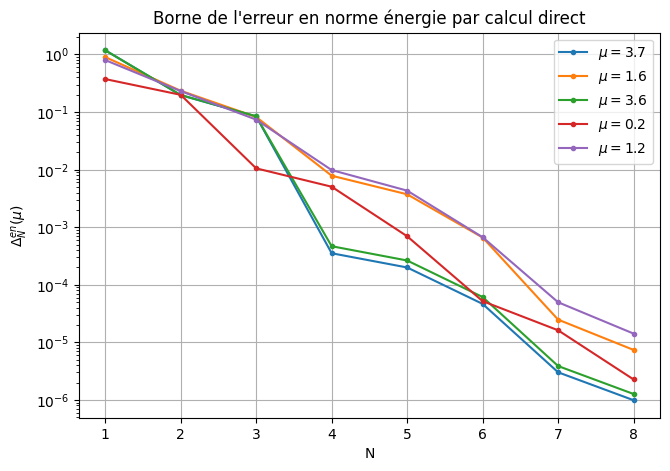

In [12]:
Ns = np.arange(1, Nmax+1)

fig, ax = plt.subplots(1, 1, figsize=(7.5, 5))
for i, mu in enumerate(mus):
    ax.semilogy(Ns, Deltas[:, i], ".-", label="$\mu=$"+str(mu[0])[:3])
ax.set_xlabel("N")
ax.set_ylabel("$\Delta_N^{en}(\mu)$")
ax.set_title("Borne de l'erreur en norme énergie par calcul direct")
ax.legend(loc="best")
plt.grid();


#### Version hors/en ligne de la borne d'erreur a posteriori

Le calcul suivra la formule du cours
$$\Vert \hat e(\mu) \Vert_X^2 = \color{blue}\underline{\mathcal{C}}^T \underline{\mathbb{X}}^\mathcal{N} \underline{\mathcal{C}} \color{normalcolor} +  \sum_{q=1}^{Q_a} \color{red}\Theta_a^q(\mu)(\underline{u}_N(\mu))^T \color{normalcolor} \left\{2\color{blue} (\underline{\mathcal{A}}^q)^T \underline{\mathbb{X}}^\mathcal{N} \underline{\mathcal{C}} \color{normalcolor} +  \sum_{q'=1}^{Q_a} \color{red} \Theta_a^{q'}(\mu) \color{blue} (\underline{\mathcal{A}}^{q'})^T \underline{\mathbb{X}}^\mathcal{N} \underline{\mathcal{A}}^q \color{normalcolor}\right\}$$
Dans notre implémentation, le terme $\underline{\mathcal{C}}$ est simplement noté `C`, et $\underline{\mathcal{A}}^q$ noté `Aq`. Ces quantités sont les solutions des équations :
- $\bar{\mathcal{A}}^{\mathcal{N}} \, C = \mathcal{F}^{\mathcal{N}}$
- $\bar{\mathcal{A}}^{\mathcal{N}} \, L^q = - \mathcal{A}^{\mathcal{N}q} Z$ = $G^q$, $\qquad q=1\ldots Q_a \qquad (Q_a = Q = Q_{max})$ 

Finalement, les quantités en <span style="color:blue">bleu</span> sont calculées et stockées hors ligne pour $N=N_{max}$. Dans le code qui suit, nous les avons respectivement notées `CC`, `CA`, et `AA` ; où les deux dernières (un vecteur de taille $N$ et une matrice $N\!\small\times\! N$) sont stockées dans des `ndarray`. Les quantités en <span style="color:red">rouge</span> sont calculées en ligne.

In [13]:
RB_alphas = [min([mu[0], 1, 10*mu[-1]]) for mu in mus]
print(RB_alphas)

[1, 1, 1, 0.2528399136400173, 1]


In [14]:
# Norme de la représentation de Riesz - PHASE HORS-LIGNE
def buildCA(Ahq, Fh, AhqBar, Z):
    C = spsolve(AhqBar, Fh)

    CC = inner(C, C, AhqBar)
    A = np.array([spsolve(AhqBar, -Aq @ Z) for Aq in Ahq])
    CA = np.array([inner(Aq.T, C, AhqBar) for Aq in A])
    AA = np.array([np.array([inner(Aq.T, Aq_, AhqBar) for Aq_ in A]) for Aq in A])

    return CC, CA, AA

In [15]:
# Norme au carré de la représentation de Riesz (||ê||²) - PHASE EN LIGNE
def RieszSNormRB(mu, u, CC, CA, AA, N):    
    ehatSNorm = CC

    for q in range(Qmax):
        temp = 2 * CA[q, :N]
        for q_ in range(Qmax):
            temp += mu[q_] * AA[q, q_, :N, :N] @ u
        ehatSNorm += mu[q] * u @ temp

    return abs(ehatSNorm)

In [16]:
Zs = buildZ_(sample1, Ahq, Fh, AhqBar, Nmax)
CC, CA, AA = buildCA(Ahq, Fh, AhqBar, Zs)
RBDeltas = []

for N in range(1, Nmax+1):
    Z = buildZ_(sample1, Ahq, Fh, AhqBar, N)
    Delta = []
    
    for mu in mus:
        alpha_LB = min([mu[0], 1, 10*mu[-1]])
        Anq, Fn, Ln = buildOff(Z, Ahq, Fh)
        un = solve(mu, Anq, Fn)
        ehatSNorm = RieszSNormRB(mu, un, CC, CA, AA, N)
        Delta.append(np.sqrt(ehatSNorm/alpha_LB))
    RBDeltas.append(Delta)
RBDeltas = np.array(RBDeltas)

In [17]:
df = pd.DataFrame({"N": np.arange(1, len(Deltas)+1)})
for i, mu in enumerate(mus):
    df["mu="+str(mu[0])[:5]] = Deltas[:, i]

df.style.set_table_attributes("style='display:inline'").set_caption("Borne de l'erreur en norme énergie")

,N,mu=3.745,mu=1.643,mu=3.686,mu=0.252,mu=1.283
0,1,1.186582,0.901689,1.182034,0.374444,0.800169
1,2,0.196758,0.234721,0.198349,0.199358,0.231518
2,3,0.084027,0.082122,0.084477,0.010533,0.073912
3,4,0.000353,0.007849,0.000468,0.005048,0.009831
4,5,0.000200,0.003729,0.000264,0.000696,0.004317
5,6,0.000046,0.000662,0.000061,0.000052,0.000670
6,7,0.000003,0.000025,0.000004,0.000016,0.000050
7,8,0.000001,0.000007,0.000001,0.000002,0.000014


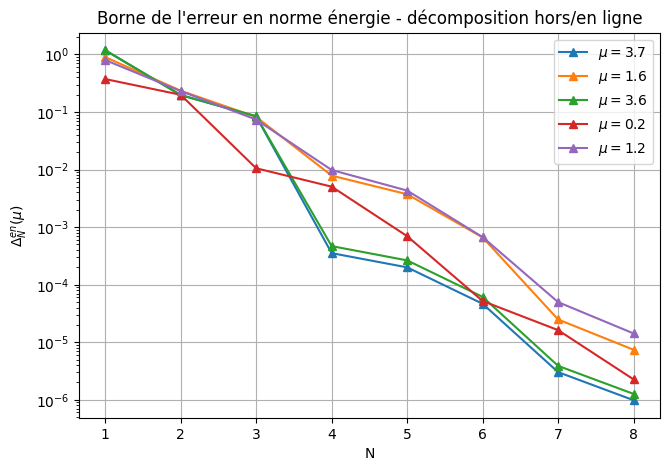

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(7.5, 5))
for i, mu in enumerate(mus):
    ax.semilogy(Ns, RBDeltas[:, i], "^-", label="$\mu=$"+str(mu[0])[:3])
ax.set_xlabel("N")
ax.set_ylabel("$\Delta_N^{en}(\mu)$")
ax.set_title("Borne de l'erreur en norme énergie - décomposition hors/en ligne")
ax.legend(loc="best")
plt.grid();

Nous constatons que les résultats correspondent à ceux obtenus en utilisant un calcul direct. Tout en étant très rapide, la décomposition hors/en ligne proposée est aussi précise que le calcul direct lorsqu'il s'agit de calculer la limite d'erreur. 

#### b) Calcul des effectivités

In [19]:
Glin = np.linspace(0.1, 10, 100)
Gln = np.logspace(-1, 1, 100)
testSample = np.concatenate((Glin, Gln))

In [20]:
# Fonction permettant de calculer facilement l'effectivité de la norme énergie.
def RBcompEff(u, un, Z, Ah, mu, tol=7.03e-8):
    alpha_LB = min([mu[0], 1, 10*mu[-1]])
    N = Z.shape[1]
    ehatSNorm = RieszSNormRB(mu, un, CC, CA, AA, N)
    Delta = np.sqrt(ehatSNorm / alpha_LB)

    e = u - Z @ un
    eNorm = norm(e, Ah)  # Norme énergie

    if (norm(e, AhqBar) > tol):
        return Delta / eNorm
    else:
        return np.nan  # Exclure si la norme X est trop basse

In [21]:
etas = []
Zs = buildZ_(sample1, Ahq, Fh, AhqBar, Nmax)

for i in testSample:
    mu = buildMu(i)
    u = solve(mu, Ahq, Fh)
    Ah = assembleA(mu, Ahq)
    eta = []

    for N in range(1, Nmax+1):
        Anq, Fn, Ln = buildOff(Zs[:, :N], Ahq, Fh)
        un = solve(mu, Anq, Fn)
        effectivity = RBcompEff(u, un, Zs[:, :N], Ah, mu)
        eta.append(effectivity)
    etas.append(eta)
etas = np.array(etas)

In [22]:
minEta = np.nanmin(etas, axis=0)
maxEta = np.nanmax(etas, axis=0)
moyEta = np.nanmean(etas, axis=0)

mask = [0, 1, 2, 3, 4, 5, 6, 7]
df = pd.DataFrame({"N": np.array(mask)+1})
df["Min"] = minEta[mask]
df["Max"] = maxEta[mask]
df["Moy"] = moyEta[mask]

df.style.set_table_attributes("style='display:inline'").set_caption('Effectivité minimale, maximale et moyenne')

,N,Min,Max,Moy
0,1,1.000000,1.691010,1.240285
1,2,1.000000,2.492369,1.617862
2,3,1.000000,2.645660,1.660508
3,4,1.000000,2.398607,1.596118
4,5,1.000000,2.631610,1.653758
5,6,1.000000,2.339145,1.580823
6,7,0.999999,2.818526,1.714274
7,8,0.484712,4.978570,1.647086


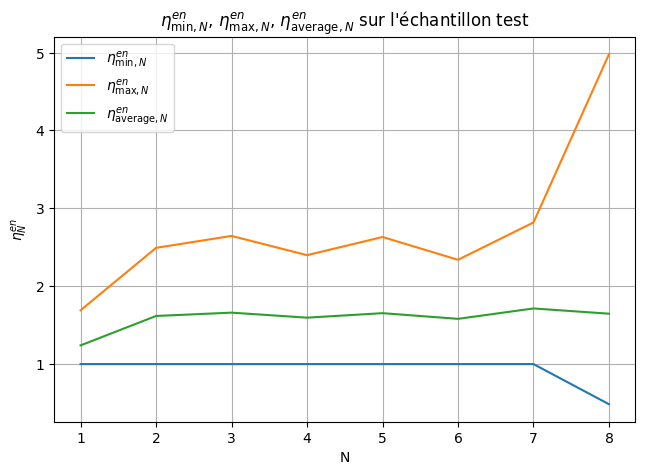

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(7.5, 5))
ax.plot(Ns, minEta, label="$\eta_{\min,N}^{en}$")
ax.plot(Ns, maxEta, label="$\eta_{\max,N}^{en}$")
ax.plot(Ns, moyEta, label="$\eta_{\mathrm{average},N}^{en}$")
ax.set_xlabel("N")
ax.set_ylabel("$\eta_{N}^{en}$")
ax.set_title("$\eta^{en}_{\min, N}$, $\eta^{en}_{\max, N}$, $\eta^{en}_{\mathrm{average}, N}$ sur l'échantillon test")
ax.legend(loc="best")
plt.grid();

Après avoir exclu de l'opération tous les points de l'échantillon test pour lesquels $\Vert u(\mu)-u_N(\mu) \Vert$ est inférieur à $7.03e-8$, nous pouvons voir que l'effectivité minimale est toujours supérieure à 1. Sur le même graphique (ou tableau), nous pouvons voir que l'effectivité maximale est toujours inférieure à la limite supérieure théorique que nous avons calculée en Q2, où nous avions $\eta_N^{en}(\mu) \leqslant \sqrt{10} \approx 3.16$.

#### c) Evaluation de l'effectivité pour $\mu=1$

In [24]:
mu = buildMu(1)
u = solve(mu, Ahq, Fh)
Ah = assembleA(mu, Ahq)
eta = []

for N in range(1, Nmax+1):
    Anq, Fn, Ln = buildOff(Zs[:, :N], Ahq, Fh)
    un = solve(mu, Anq, Fn)
    eff = RBcompEff(u, un, Zs[:, :N], Ah, mu, 1e-11)
    eta.append(eff)
eta = np.array(eta)

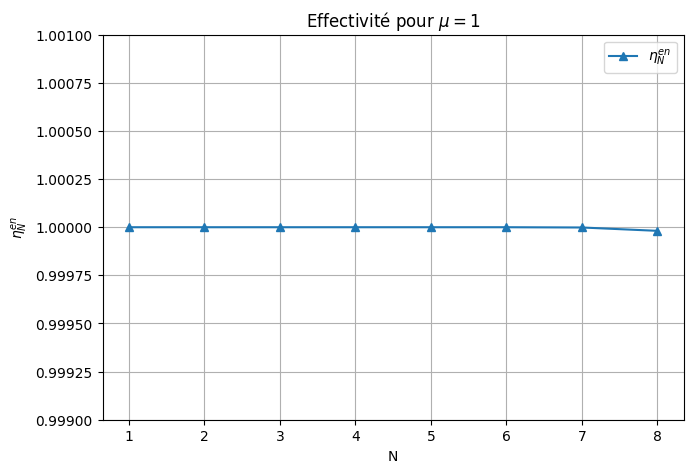

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(7.5, 5))
ax.plot(Ns, eta, '^-', label="$\eta_{N}^{en}$")
ax.set_xlabel("N")
ax.set_ylabel("$\eta_{N}^{en}$")
ax.set_ylim(0.999, 1.001)
ax.set_title("Effectivité pour $\mu=1$")
ax.legend(loc="best")
plt.grid();

Pour $\mu =1 = \bar{\mu}$, l'effectivité est toujours égale à 1. Ceci est dû au fait que la norme d'énergie est la même que la norme X.  
Dans ce cas, la limite supérieure de $\eta_{N}^{en}(\mu)$ est donnée par $\sqrt{\frac{\gamma_{UB}(\mu)}{\alpha_{LB}(\mu)}}$ = $\sqrt{\frac{\gamma_{UB}(\bar{\mu})}{\alpha_{LB}(\bar{\mu})}}$.  
Il est clair que $\alpha_{LB}(\bar{\mu}) = 1$ et $\gamma_{UB}(\bar{\mu})=1$, suivant la définition de la norme X : $\Vert u \Vert_X = a(u,u;\bar{\mu})$.  
Comme $1$ est aussi une borne inférieure pour $\eta_{N}^{en}(\mu)$, on obtient $\eta_{N}^{en}(\mu) = 1$.

#### d) Erreur exacte et borne d'erreur pour $\mu = 0.1$

In [26]:
mu = buildMu(0.1)
u = solve(mu, Ahq, Fh)
Ah = assembleA(mu, Ahq)

exact = []
bornes = []
bornesFE = []

for N in range(1, Nmax+1):
    Z = Zs[:, :N]
    Anq, Fn, Ln = buildOff(Z, Ahq, Fh)
    un = solve(mu, Anq, Fn)
    e = u - Z @ un
    exact.append(norm(e, AhqBar))

    alpha_LB = min([mu[0], 1, 10*mu[-1]])
    ehatSNorm = RieszSNormRB(mu, un, CC, CA, AA, N)
    bornes.append(np.sqrt(ehatSNorm / alpha_LB))

    ehatNormFE = RieszNormFE(Ah, Fh, un, Z, AhqBar)
    bornesFE.append(ehatNormFE/np.sqrt(alpha_LB))
exact = np.array(exact)
bornes = np.array(bornes)
bornesFE = np.array(bornesFE)

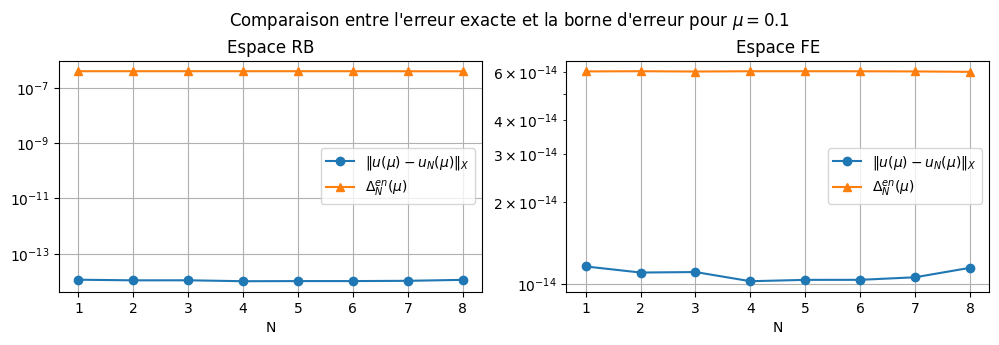

In [27]:
fig, ax = plt.subplots(1, 2, figsize=(12, 3))
ax[0].semilogy(Ns, exact, "o-", label="$\Vert u(\mu)-u_N(\mu) \Vert_X$")
ax[0].semilogy(Ns, bornes, "^-", label="$\Delta_N^{en}(\mu)$")
ax[0].set_xlabel("N")
ax[0].set_title("Espace RB")
ax[0].legend(loc="best")
ax[0].grid()
ax[1].semilogy(Ns, exact, "o-", label="$\Vert u(\mu)-u_N(\mu) \Vert_X$")
ax[1].semilogy(Ns, bornesFE, "^-", label="$\Delta_N^{en}(\mu)$")
ax[1].set_xlabel("N")
ax[1].set_title("Espace FE")
ax[1].legend(loc="best")
ax[1].grid()
plt.suptitle("Comparaison entre l'erreur exacte et la borne d'erreur pour $\mu=0.1$", y=1.05);

L'erreur exacte est proche de zéro (inférieure à la précision en virgule flottante $10^{-14}$).  
Celle calculée dans l'espace RB semble est bien plus importante. Ceci est dû au fait que la valeur $\mu=0.1$ a été utilisée pour la construction de notre base réduite orthonormalisée. En effet, puisque celle-ci est calculée à partir de son carré et qu'il devrait être nul, la précision machine fait qu'une fois passé à la racine, elle semble ne pas descendre sous $10^{-7}$.

### Q4.

In [28]:
sample3 = loadSample("sample3")
Nmax = 46
Zs = buildZ_(sample3, Ahq, Fh, AhqBar, Nmax)

#### a) Implémenter une version hors ligne/en ligne du calcul de la limite d'erreur a posteriori en suivant la décomposition computationnelle montrée dans le cours.

In [29]:
ks = np.random.uniform(0.1, 10, 5)
Bis = np.random.uniform(0.01, 1, 5)

In [30]:
Deltas = []

for i in range(len(ks)):
    mu = buildMu(ks[i], Bis[i])
    Ah = assembleA(mu, Ahq)
    alpha_LB = min([mu[0], 1, 10*mu[-1]])
    Delta = []

    for N in range(1, Nmax+1):
        Z = Zs[:, :N]
        Anq, Fn, Ln = buildOff(Z, Ahq, Fh)
        un = solve(mu, Anq, Fn)
        ehatNorm = RieszNormFE(Ah, Fh, un, Z, AhqBar)
        Delta.append(ehatNorm / np.sqrt(alpha_LB))
    Deltas.append(Delta)
Deltas = np.array(Deltas)

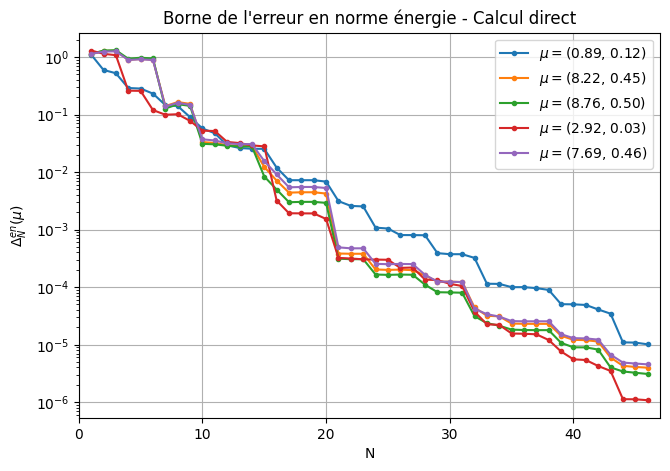

In [31]:
Ns = np.arange(1, Nmax+1)

fig, ax = plt.subplots(1, 1, figsize=(7.5, 5))
for i, mu in enumerate(zip(ks, Bis)):
    ax.semilogy(Ns, Deltas[i, :], ".-", label="$\mu=$"+"(%0.2f" % mu[0]+", %0.2f)" % mu[1])
ax.set_xlabel("N")
ax.set_xlim(0, Nmax+1)
ax.set_ylabel("$\Delta_N^{en}(\mu)$")
ax.set_title("Borne de l'erreur en norme énergie - Calcul direct")
ax.legend(loc="best")
plt.grid();


#### Décomposition hors/en ligne

In [32]:
CC, CA, AA = buildCA(Ahq, Fh, AhqBar, Zs)

In [33]:
RBDeltas = []

for i in range(len(ks)):
    mu = buildMu(ks[i], Bis[i])
    Ah = assembleA(mu, Ahq)
    alpha_LB = min([mu[0], 1, 10*mu[-1]])
    Delta = []

    for N in range(1, Nmax+1):
        Z = Zs[:, :N]
        Anq, Fn, Ln = buildOff(Z, Ahq, Fh)
        un = solve(mu, Anq, Fn)
        ehatSNorm = RieszSNormRB(mu, un, CC, CA, AA, N)
        Delta.append(np.sqrt(ehatSNorm/alpha_LB))
    RBDeltas.append(Delta)
RBDeltas = np.array(RBDeltas)

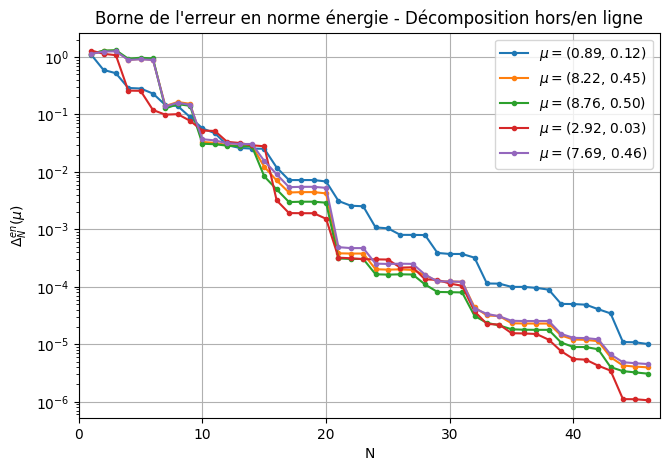

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(7.5, 5))
for i, mu in enumerate(zip(ks, Bis)):
    ax.semilogy(Ns, RBDeltas[i, :], ".-", label="$\mu=$"+"(%0.2f" % mu[0]+", %0.2f)" % mu[1])
ax.set_xlabel("N")
ax.set_xlim(0, Nmax+1)
ax.set_ylabel("$\Delta_N^{en}(\mu)$")
ax.set_title("Borne de l'erreur en norme énergie - Décomposition hors/en ligne")
ax.legend(loc="best")
plt.grid();


Il ressort clairement des deux figures précédentes que le calcul direct et la décomposition hors/en ligne produisent les mêmes résultats, tout comme dans le cas I.

#### b) Calcul de $\eta^{en}_{\min, N}$, $\eta^{en}_{\max, N}$, $\eta^{en}_{\mathrm{average}, N}$

In [35]:
links, logks = np.linspace(0.1, 10, 10), np.logspace(-1, 1, 10)
linBis, logBis = np.linspace(0.01, 1, 10), np.logspace(-2, 0, 10)
linXi = np.array([el for el in product(links, linBis)])
logXi = np.array([el for el in product(logks, logBis)])

testSample = np.concatenate((linXi, logXi))


In [36]:
etas = []

for k, Bi in testSample:
    mu = buildMu(k, Bi)
    u = solve(mu, Ahq, Fh)
    Ah = assembleA(mu, Ahq)
    eta = []

    for N in range(1, Nmax+1):
        Anq, Fn, Ln = buildOff(Zs[:, :N], Ahq, Fh)
        un = solve(mu, Anq, Fn)
        effectivity = RBcompEff(u, un, Zs[:, :N], Ah, mu, 1e-7)
        eta.append(effectivity)        
    etas.append(eta)
etas = np.array(etas)

In [38]:
minEta = np.nanmin(etas, axis=0)
maxEta = np.nanmax(etas, axis=0)
moyEta = np.nanmean(etas, axis=0)

mask = np.array([5, 10, 20, 30, 40])
df = pd.DataFrame({"N": mask})
df["Min"] = minEta[mask-1]
df["Max"] = maxEta[mask-1]
df["Moy"] = moyEta[mask-1]

df.style.set_table_attributes("style='display:inline'").set_caption('Effectivité minimale, maximale et moyenne')

,N,Min,Max,Moy
0,5,1.017255,6.685083,2.058090
1,10,1.031082,6.906718,2.135940
2,20,1.053642,6.896021,2.143180
3,30,1.054003,7.031898,1.997941
4,40,1.043992,6.489187,1.916736


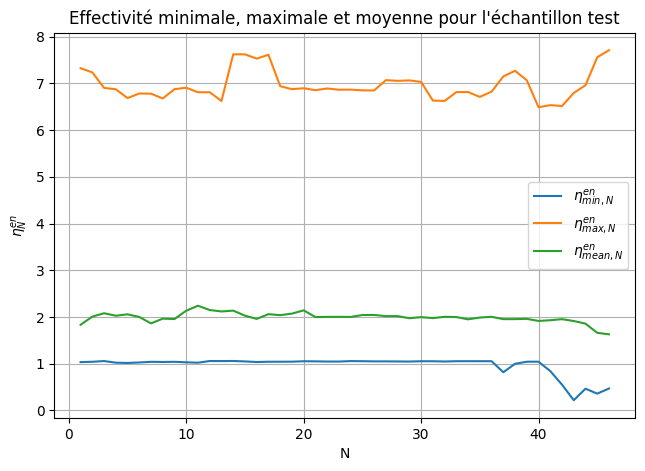

In [39]:
fig, ax = plt.subplots(1, 1, figsize=(7.5, 5))
ax.plot(Ns, minEta, label="$\eta_{min,N}^{en}$")
ax.plot(Ns, maxEta, label="$\eta_{max,N}^{en}$")
ax.plot(Ns, moyEta, label="$\eta_{mean,N}^{en}$")
ax.set_xlabel("N")
ax.set_ylabel("$\eta_{N}^{en}$")
ax.set_title("Effectivité minimale, maximale et moyenne pour l'échantillon test")
ax.legend(loc="best")
plt.grid();

L'effectivité minimale est effectivement supérieure à 1.  
Comme dans le cas I, ce résultat était attendu. Cependant, tous les points de l'échantillon test dont la norme d'erreur X est inférieure à $10^{-7}$ ont dû être exclus de l'étude.  
On peut également voir que l'effectivité maximale est plus petite que la limite théorique calculée à Q2 (où nous avons trouvé $\eta_N^{en}(\mu) \leqslant 10$).

#### Testons notre borne supérieure théorique pour l'efficacité.
Calculons les bornes supérieures théoriques de l'efficacité.  
En norme énergie, nous avons montré que :
$$
1 \leqslant \eta_{N}^{en} \leqslant \sqrt \frac{\gamma_{UB}(\mu)}{\alpha_{LB}(\mu)}
$$

Les bornes inférieures et supérieures de $\alpha(\mu)$ et $\gamma(\mu)$ sont calculées ci-dessous en utilisant respectivement les algorithmes min-$\theta$ et max-$\theta$.

In [40]:
etaBounds = []

for i in testSample:
    mu = buildMu(i[0], i[1])
    Ah = assembleA(mu, Ahq)
    eta = []

    for _ in range(Nmax):
        alpha_LB = min(mu[0], 1, 10*mu[-1])
        gamma_UB = max(mu[0], 1, 10*mu[-1])
        eta.append(np.sqrt(gamma_UB / alpha_LB))
    etaBounds.append(eta)
etaBounds = np.array(etaBounds)
etaBounds = np.max(etaBounds, axis=0)

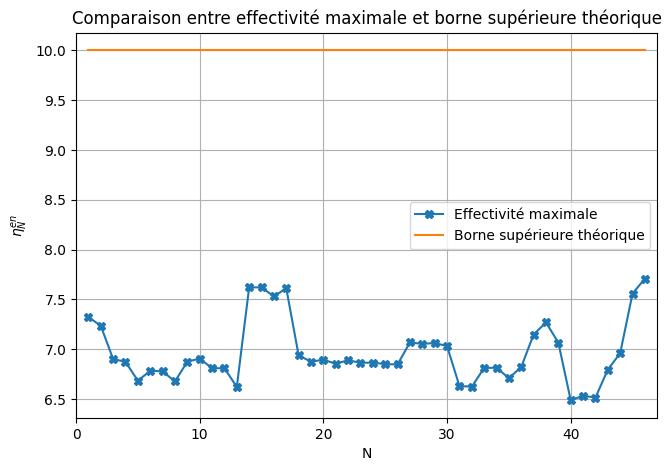

In [41]:
fig, ax = plt.subplots(1, 1, figsize=(7.5, 5))
ax.plot(Ns, maxEta, "X-", label="Effectivité maximale")
ax.plot(Ns, etaBounds, label="Borne supérieure théorique")
ax.set_xlabel("N")
ax.set_ylabel("$\eta_{N}^{en}$")
ax.set_xlim(0, Nmax+1)
ax.set_title("Comparaison entre effectivité maximale et borne supérieure théorique")
ax.legend(loc="best")
plt.grid();

Cela confirme que la borne supérieure théorique est effectivement toujours supérieure à l'effectivité maximale numérique.

## Partie 3 - Borne de sortie de la base réduite

### Q5.

In [42]:
sample3 = loadSample("sample3")
Zs = buildZ_(sample3, Ahq, Fh, AhqBar, Nmax)
Anq, Fn, Ln = buildOff(Z, Ahq, Fh)

#### a) Calcul de la borne d'erreur de sortie

La borne d'erreur de sortie est la valeur au carré de la borne d'erreur en norme énergie.
$$
\Delta^s_N(\mu) = \Delta^{en}_N(\mu)^2 
$$

In [43]:
ks = loguniform.rvs(0.1, 10, size=5)
Bis = loguniform.rvs(0.01, 1, size=5)

In [44]:
CC, CA, AA = buildCA(Ahq, Fh, AhqBar, Zs)

In [45]:
DeltaSList = []

for i in range(len(ks)):
    mu = buildMu(ks[i], Bis[i])
    alpha_LB = min([mu[0], 1, 10*mu[-1]])
    DeltaS = []

    for N in range(1, Nmax+1):
        Z = Zs[:, :N]
        Anq, Fn, Ln = buildOff(Z, Ahq, Fh)
        un = solve(mu, Anq, Fn)
        ehatSNorm = RieszSNormRB(mu, un, CC, CA, AA, N)
        DeltaS.append(ehatSNorm / alpha_LB)
    DeltaSList.append(DeltaS)
DeltaSList = np.array(DeltaSList)

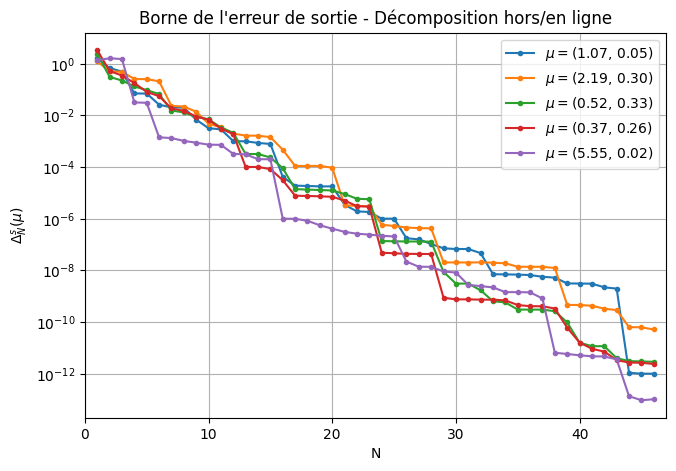

In [46]:
fig, ax = plt.subplots(1, 1, figsize=(7.5, 5))
for i, mu in enumerate(zip(ks, Bis)):
    ax.semilogy(Ns, DeltaSList[i, :], ".-", label="$\mu=$"+"(%0.2f" % mu[0]+", %0.2f)" % mu[1])
ax.set_xlabel("N")
ax.set_xlim(0, Nmax+1)
ax.set_ylabel("$\Delta_N^{s}(\mu)$")
ax.set_title("Borne de l'erreur de sortie - Décomposition hors/en ligne")
ax.legend(loc="best")
plt.grid();

Comme l'erreur en norme énergie dans la partie 2, l'erreur de sortie converge lorsque $N$ augmente.

#### b) Calculons les effectivités minimale, maximale et moyenne de la production.

La formule de l'effectivité de la production est
$$
\eta_{N}^s = \frac{\Delta^s_N(\mu)}{\vert s(\mu)-s_N(\mu) \vert}
$$

In [47]:
# Fonction permettant de calculer facilement l'effectivité de la production
def compOutEff(u, un, Z, Lh, Ln, mu):
    alpha_LB = min([mu[0], 1, 10*mu[-1]])
    N = Z.shape[1]
    ehatSNorm = RieszSNormRB(mu, un, CC, CA, AA, N)
    DeltaS = ehatSNorm / alpha_LB
    e = Lh.T @ u - Ln.T @ un
    eNorm = np.abs(e)

    if (eNorm >= 1e-11):
        return DeltaS / eNorm
    return np.nan

In [48]:
etas = []

for i in testSample:
    mu = buildMu(i[0], i[1])
    u = solve(mu, Ahq, Fh)
    Ah = assembleA(mu, Ahq)
    eta = []

    for N in range(1, Nmax+1):
        Anq, Fn, Ln = buildOff(Zs[:, :N], Ahq, Fh)
        un = solve(mu, Anq, Fn)
        eff = compOutEff(u, un, Zs[:, :N], Fh, Ln, mu)
        eta.append(eff)
    etas.append(np.array(eta))
etas = np.array(etas)

In [49]:
minEta = np.nanmin(etas, axis=0)
maxEta = np.nanmax(etas, axis=0)
moyEta = np.nanmean(etas, axis=0)

mask = np.array([5, 10, 20, 30, 40])
df = pd.DataFrame({"N": mask})
df["Min"] = minEta[mask-1]
df["Max"] = maxEta[mask-1]
df["Moy"] = moyEta[mask-1]

df.style.set_table_attributes("style='display:inline'").set_caption('Effectivité minimale, maximale et moyenne')

,N,Min,Max,Moy
0,5,1.034808,44.690338,5.104766
1,10,1.063130,47.702498,5.730601
2,20,1.110162,44.232430,5.415626
3,30,1.110923,43.650415,4.790574
4,40,1.089921,6.698449,2.898851


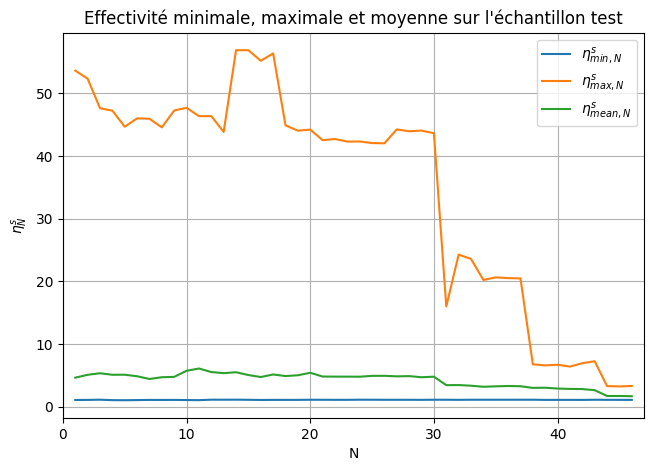

In [50]:
fig, ax = plt.subplots(1, 1, figsize=(7.5, 5))
ax.plot(Ns, minEta, label="$\eta_{min,N}^{s}$")
ax.plot(Ns, maxEta, label="$\eta_{max,N}^{s}$")
ax.plot(Ns, moyEta, label="$\eta_{mean,N}^{s}$")
ax.set_xlabel("N")
ax.set_xlim(0, Nmax+1)
ax.set_ylabel("$\eta_{N}^{s}$")
ax.set_title("Effectivité minimale, maximale et moyenne sur l'échantillon test")
ax.legend(loc="best")
plt.grid();

Cette figure (et le tableau précédent) confirme que l'effectivité maximale de la production est toujours inférieure à la limite supérieure théorique $\eta_N^s(\mu) \leqslant 100$ calculée à Q2.  
Par rapport à l'effectivité énergétique de Q4 où une limite était imposée à la norme X de l'erreur, il n'était pas nécessaire de retirer de l'opération tous les points pour lesquels l'erreur de sortie était inférieure à $10^{-7}$, c'est pourquoi nous avons laissé $10^{-11}$ comme suggéré dans l'énoncé de la question.

#### c) Valeur requise pour une précision de 1%. 

In [51]:
ntest = 200
accList = np.zeros(ntest)
acc = 1
N = 1

while acc > 0.01 and N < Nmax+1:
    N += 1
    Anq, Fn, Ln = buildOff(Zs[:, :N], Ahq, Fh)

    for k in range(ntest):
        mu = buildMu(testSample[k, 0], testSample[k, 1])
        u = solve(mu, Ahq, Fh)
        Troot = Fh @ u
        un = solve(mu, Anq, Fn)
        Trootn = Ln @ un
        accList[k] = abs(Troot-Trootn) / abs(Troot)
    acc = np.max(accList)

In [52]:
print("Valeur requise pour une précision de 1%:", N)
print("L'erreur réelle pour N =", N, "est environ %0.6f" % (acc*abs(Troot)))

Valeur requise pour une précision de 1%: 10
L'erreur réelle pour N = 10 est environ 0.002687


La valeur de $N$ nécessaire pour obtenir une précision relative de la borne de sortie d'environ $1\%$ est $N=10$, et l'erreur vraie pour cette valeur de $N$ est $\vert\gamma_{root}(\mu)-\gamma_{root,N}(\mu) \vert = 0,002687$.

#### d) Comparaison en ligne des coûts de calcul

Comparaison entre le temps nécessaire pour calculer la borne d'erreur de sortie $\Delta^s_N(\mu)$ et le temps nécessaire pour calculer $s_N(\mu)$ en fonction de $N$. Les temps d'exécution rapportés seront des moyennes, sur 10 exécutions des mêmes codes.

In [53]:
def TimedDelta():
    alpha_LB = min([mu[0], 1, 10*mu[-1]])
    Z = Zs[:, :N]
    Anq, Fn, _ = buildOff(Z, Ahq, Fh)
    un = solve(mu, Anq, Fn)
    ehatSNorm = RieszSNormRB(mu, un, CC, CA, AA, N)

    return ehatSNorm / alpha_LB


def TimedOutputOnline():
    Z = Zs[:, :N]
    Anq, Fn, Ln = buildOff(Z, Ahq, Fh)
    un = solve(mu, Anq, Fn)

    return Ln @ un


def TimedOutputOffline():
    u = solve(mu, Ahq, Fh)

    return Fh @ u

In [54]:
from random import randrange
times1 = np.empty(Nmax)
times2 = np.empty(Nmax)

for N in range(1, Nmax+1):
    k = randrange(200)
    mu = buildMu(testSample[k, 0], testSample[k, 1])
    times1[N-1] = timeit(TimedDelta, number=ntest)
    times2[N-1] = timeit(TimedOutputOnline, number=ntest)
times1 /= ntest
times2 /= ntest

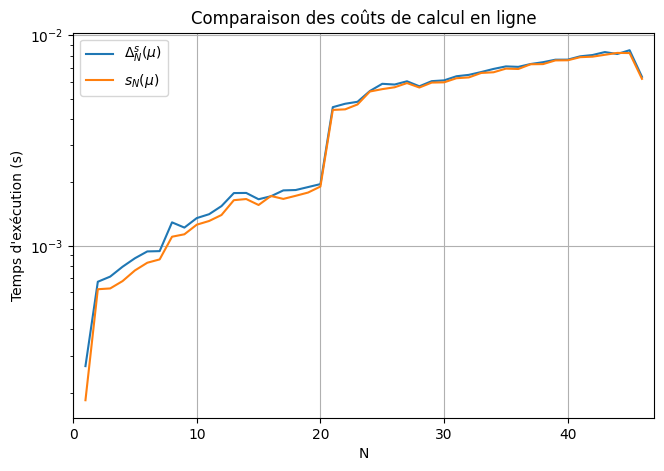

In [55]:
fig, ax = plt.subplots(1, 1, figsize=(7.5, 5))
ax.semilogy(Ns, times1, label="$\Delta^s_N(\mu)$")
ax.semilogy(Ns, times2, label="$s_N(\mu)$")
ax.set_xlabel("N")
ax.set_xlim(0, Nmax+1)
ax.set_ylabel("Temps d'exécution (s)")
ax.set_title("Comparaison des coûts de calcul en ligne")
ax.legend(loc="best")
plt.grid();

Le calcul de la phase en ligne de $\Delta^s_N(\mu)$ prend presque autant de temps que le calcul de la solution approchée $u_N$. C'est un résultat intéressant, car cela signifie que nous pouvons évaluer l'erreur que nous faisons sur notre résultat, sans jamais avoir besoin de calculer ledit résultat, tout cela au même coût.

#### e) Une autre comparaison des coûts de calcul

Comparaison entre le temps nécessaire pour calculer la véritable sortie $s(\mu)$ et celui nécessaire pour calculer $s_N(\mu)$ et la borne d'erreur de sortie $\Delta^s_N(\mu)$ en fonction de $N$. Comme pour la comparaison précédente, on prend une moyenne sur 10 exécutions.

In [56]:
def TimedDeltaOut():
    alpha_LB = min([mu[0], 1, 10*mu[-1]])
    Z = Zs[:, :N]
    Anq, Fn, Ln = buildOff(Z, Ahq, Fh)
    un = solve(mu, Anq, Fn)
    ehatSNorm = RieszSNormRB(mu, un, CC, CA, AA, N)

    return ehatSNorm / alpha_LB, Ln @ un

In [57]:
times1 = np.empty(Nmax)
times2 = np.empty(Nmax)

for N in range(1, Nmax+1):
    k = randrange(200)
    mu = buildMu(testSample[k, 0], testSample[k, 1])
    times1[N-1] = timeit(TimedOutputOffline, number=ntest)
    times2[N-1] = timeit(TimedDeltaOut, number=ntest)
times1 /= ntest
times2 /= ntest

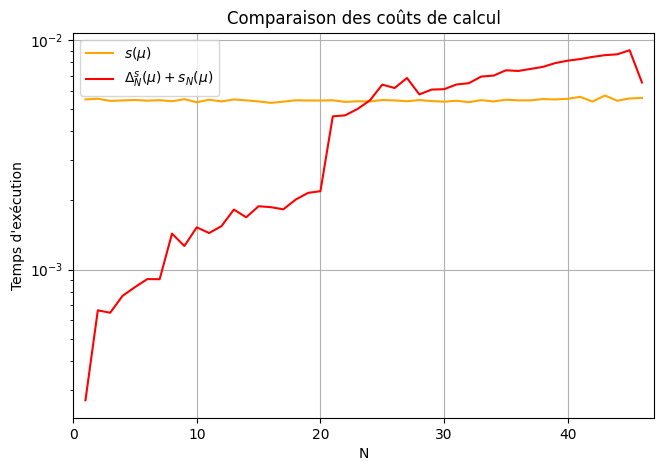

In [58]:
fig, ax = plt.subplots(1, 1, figsize=(7.5, 5))
ax.semilogy(Ns, times1, label="$s(\mu)$", color="orange")
ax.semilogy(Ns, times2, label="$\Delta^s_N(\mu) + s_N(\mu)$", color="r")
ax.set_xlabel("N")
ax.set_xlim(0, Nmax+1)
ax.set_ylabel("Temps d'exécution")
ax.set_title("Comparaison des coûts de calcul")
ax.legend(loc="best")
plt.grid();

In [59]:
print("Valeur de N à partir de laquelle le calcul FE est moins coûteux :", np.argmax(times2 > times1))

Valeur de N à partir de laquelle le calcul FE est moins coûteux : 23


La dernière figure montre que le calcul de $s(\mu)$ ne dépend pas de $N$. Elle montre également que le calcul en ligne de $\Delta^s_N(\mu)$ et $s_N(\mu)$ est plus coûteux que le calcul de $s(\mu)$, lorsque $N \geqslant 23$. Cela est dû à la manière dont la norme de la représentation de Riesz du résidu est calculée (en utilisant une approche inefficace en ligne par boucles imbriquées). Tout cela signifie que le calcul RB devient moins efficace (par rapport au calcul FE) dès que $N$ atteint $23$.

## Part 4 - Greedy Sampling Procedure

Construisons les ensembles d'échantillons $S_N$ à l'aide de l'algorithme glouton.  
Il est important de noter que nous avons ajouté une étape d'orthonormalisation à l'algorithme. Ainsi, la matrice RB résultante est orthonormée et prête à être utilisée.

#### Algorithme glouton (greedy)
\begin{align*}
\text{tant}&\text{ que }\Delta_{N-1}^{\max} \geqslant \varepsilon_{\mathrm{tol}, \min} \\
    &N = N+1;\\
    &\mu_N^* = \argmax_{\mu\in\Xi_{\mathrm{train}}} \Delta_{N-1}(\mu);\\
    &\Delta_{N-1}^{\max} = \Delta_{N-1}(\mu_N^*);\\
    &S_N = S_{N-1} \cup \mu_N^*;\\
    &X_N = X_{N-1} + \mathrm{span}\{u^\mathcal{N}(\mu_N^*)\} \\
\text{fin t}&\text{ant que}
\end{align*}

Pendant la procédure d'échantillonnage glouton, seuls certains termes sont calculés afin d'évaluer la limite d'erreur. $N_{max}$ est choisi comme la taille de l'échantillon train.

In [60]:
# Gram-schmidt
def GramSchmidt(Z, u, AhqBar):
    nbCol = Z.shape[1]
    z = u

    if nbCol > 0 and len(Z) > 0:
        for k in range(0, nbCol):
            z -= proj(u, Z[:, k], AhqBar)
        z = z / norm(z, AhqBar)

    return z

In [61]:
# Fonction permettant de calculer uniquement les données nécessaires
def updateOffline(Ahq, AhqBar, Z, N, C, A, CA, AA):
    for q in range(Qmax):
        Gnq = -Ahq[q] @ Z[:, N-1]
        Lnq = spsolve(AhqBar, Gnq)
        A[q, :, N-1] = Lnq
        CA[q, N-1] = inner(C, Lnq, AhqBar)
        for q_ in range(Qmax):
            Lq_ = A[q_, :, :N]
            AA[q, q_, N-1, :N] = inner(Lnq.T, Lq_, AhqBar)

    for q in range(Qmax):
        Lq = A[q, :, :N]
        for q_ in range(Qmax):
            Lnq_ = A[q_, :, N-1]
            AA[q, q_, :N, N-1] = inner(Lq.T, Lnq_, AhqBar)


def maxDelta(trainSample, Z, N, Ahq, Fh, AhqBar, C, A, CC, CA, AA, cas):
    updateOffline(Ahq, AhqBar, Z, N, C, A, CA, AA)
    maxDelta = 0
    muOpt = None

    for el in trainSample:
        if cas == 2:
            mu = buildMu(el[0], el[1])
        else:
            mu = buildMu(el)

        Anq, Fn, _ = buildOff(Z, Ahq, Fh)
        un = solve(mu, Anq, Fn)

        Ah = assembleA(mu, Ahq)
        unNorm = norm(Z[:, :N]@un, Ah)
        alpha_LB = min([mu[0], 1, 10*mu[-1]])
        ehatSNorm = RieszSNormRB(mu, un, CC, CA, AA, N)
        Delta = np.sqrt(ehatSNorm / alpha_LB) / unNorm

        if Delta > maxDelta:
            maxDelta = Delta
            muOpt = mu

    return maxDelta, muOpt


In [62]:
def greedySampling(Nmax, trainSample, Ahq, Fh, AhqBar, C, A, CC, CA, AA, muMin, tol=1e-6):
    outSample = []
    DeltaMax = []
    cas = len(trainSample.shape)
    mu = muMin
    Z = np.array([])
    Z = Z[:, np.newaxis]
    N = 0
    err = 10 * tol

    while N < Nmax and err > tol:
        N += 1
        ntrain = len(trainSample)
        uh = solve(mu, Ahq, Fh)
        xi = GramSchmidt(Z, uh, AhqBar)
        xi = xi[:, np.newaxis]

        if N > 1:
            Z = np.concatenate([Z, xi], axis=1)
        else:
            Z = np.concatenate([Z, xi])

        if cas == 1:
            outSample.append(mu[0])
            trainSample = np.delete(trainSample, np.where(trainSample==mu[0]))
        else:
            outSample.append((mu[0], mu[-1]))
            for i in range(ntrain):
                if trainSample[i][0] == mu[0] and trainSample[i][1] == mu[-1]:
                    trainSample = np.delete(trainSample, [i], axis=0)
                    break

        err, mu = maxDelta(trainSample, Z, N, Ahq, Fh, AhqBar, C, A, CC, CA, AA, cas)
        if N % 5 == 0:
            print("La borne d'erreur relative à l'étape", N, "est :", err)
        DeltaMax.append(err)
    if N % 5 != 0:
        print("La borne d'erreur relative à l'étape", N, "est:", err)

    return Z, np.array(outSample), np.array(DeltaMax)


### Q6. Algorithme glouton appliqué au cas I.

#### a) Quelle est la valeur de $N_{\mathrm{max}}$ pour obtenir la précision souhaitée ?

In [63]:
Nmax = 100
NCal = AhqBar.shape[0]
trainSample = np.logspace(-1, 1, num=Nmax)

C = spsolve(AhqBar, Fh)
CC = inner(C, C, AhqBar)
A = np.zeros((Qmax, NCal, Nmax))
CA = np.zeros((Qmax, Nmax))
AA = np.zeros((Qmax, Qmax, Nmax, Nmax))
muMin = buildMu(0.1)

Z, outSample, DeltaMax = greedySampling(Nmax, trainSample, Ahq, Fh, AhqBar, C, A, CC, CA, AA, muMin)

print("\nÉchantillon :\n", outSample)

La borne d'erreur relative à l'étape 5 est : 0.0012254612628583045
La borne d'erreur relative à l'étape 9 est: 8.008919750411898e-07

Échantillon :
 [ 0.1     10.       1.78865  0.26561  0.61359  5.21401  0.13849  0.18307
  3.12572]


Comme l'indiquent les résultats ci-dessus, la valeur requise de $N_{max}$ pour obtenir la précision souhaitée de $10^{-6}$ est de $9$. Traçons une séquence de graphiques montrant ce qui se passe à chaque étape de l'algorithme d'échantillonnage glouton.

In [64]:
Rel_Errors = []
EnErrBound = []
Nmax = Z.shape[1]

for el in trainSample:
    mu = buildMu(el)
    alpha_LB = min([mu[0], 1, 10*mu[-1]])
    u = solve(mu, Ahq, Fh)
    Ah = assembleA(mu, Ahq)
    rel = []
    bornes = []

    for N in range(1, Nmax+1):
        Anq, Fn, Ln = buildOff(Z[:, :N], Ahq, Fh)
        un = solve(mu, Anq, Fn)

        e = u - Z[:, :N]@un
        eNorm = norm(e, AhqBar)
        unNorm = norm((Z[:, :N]@un), Ah)
        rel.append(eNorm/unNorm)

        ehatSNorm = RieszSNormRB(mu, un, CC, CA, AA, N)
        Delta = np.sqrt(ehatSNorm/alpha_LB)
        bornes.append(Delta/unNorm)
    Rel_Errors.append(rel)
    EnErrBound.append(bornes)
Rel_Errors = np.array(Rel_Errors)
EnErrBound = np.array(EnErrBound)

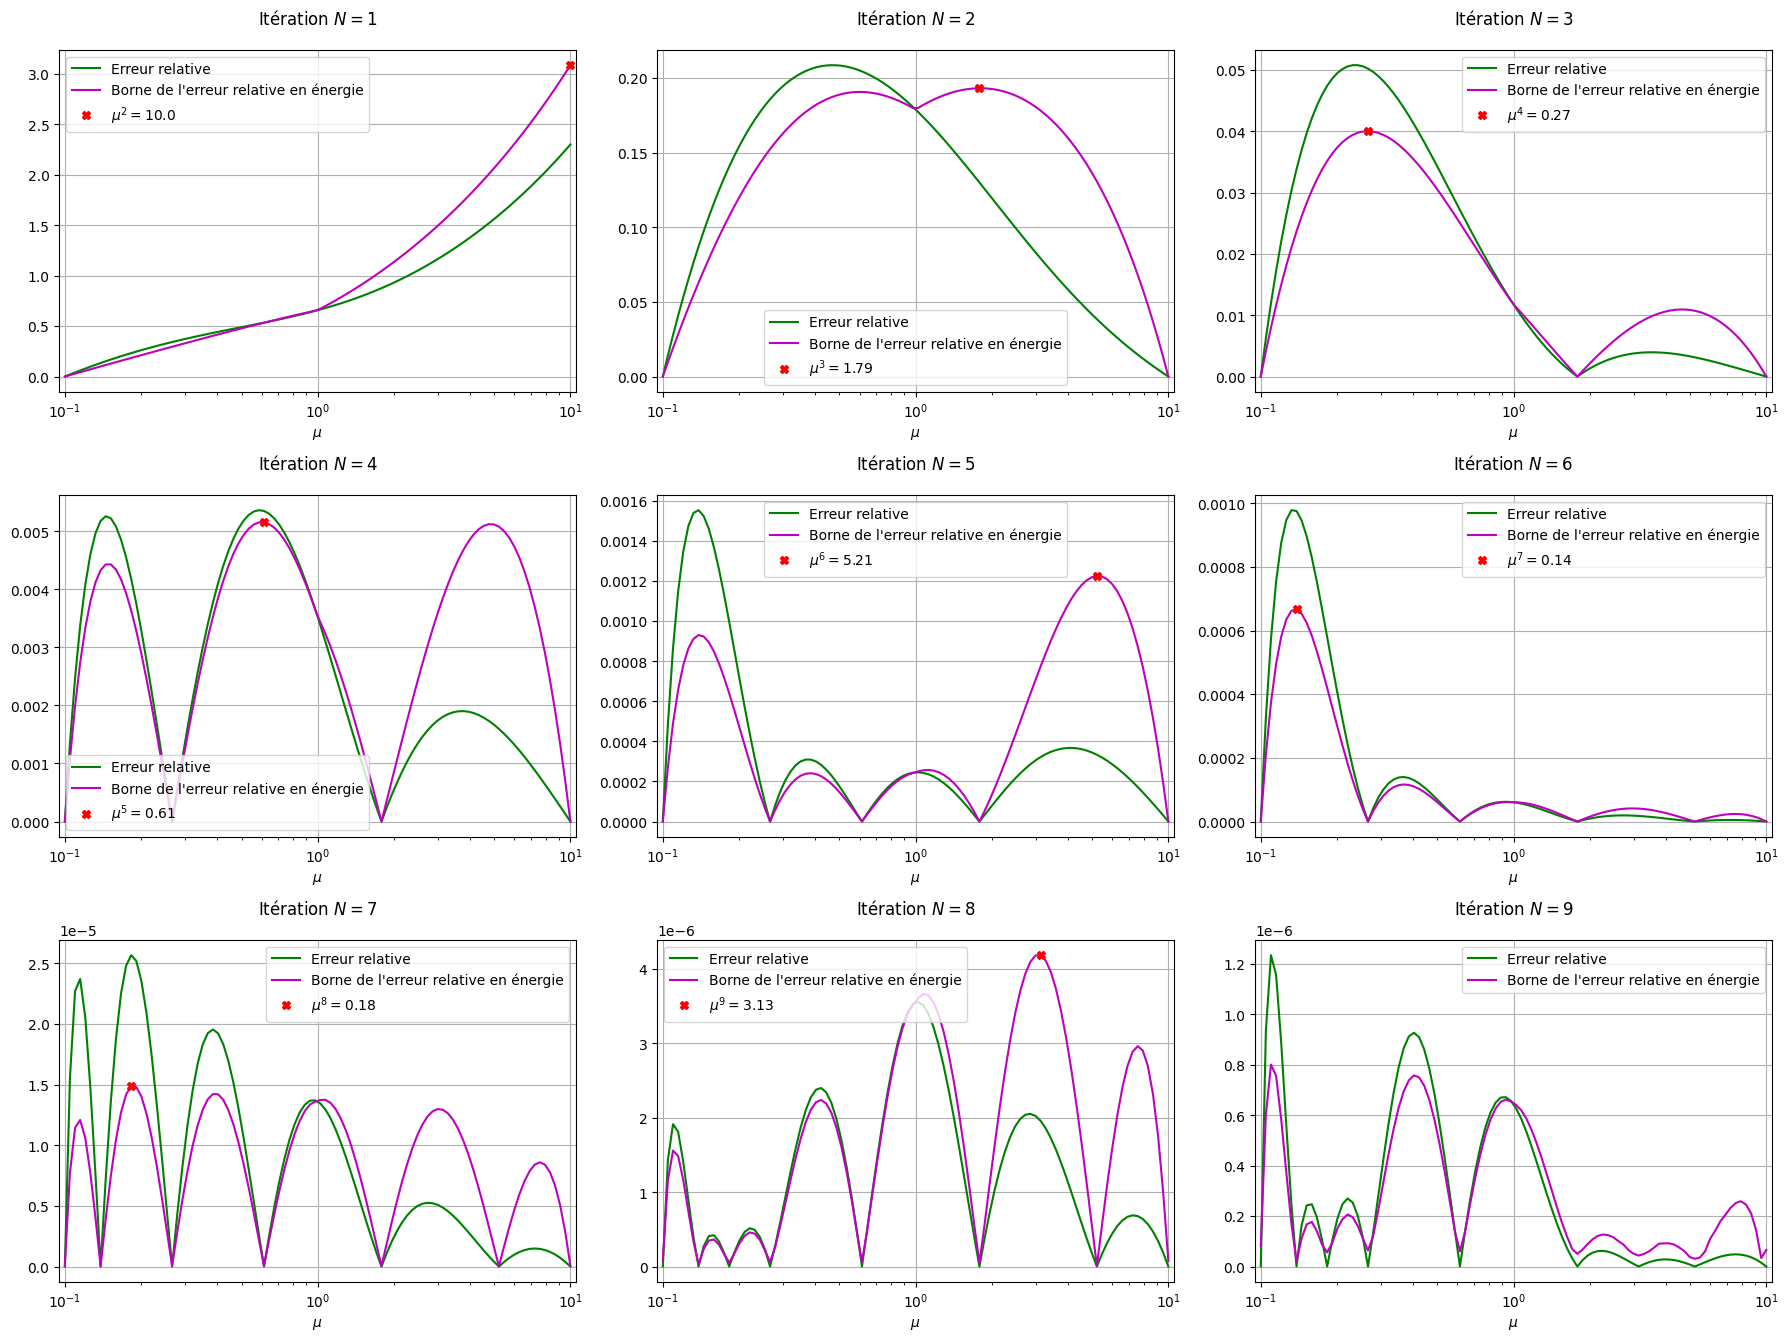

In [65]:
fig, ax = plt.subplots((Nmax+1)//3, 3, figsize=(18, 1.5*Nmax))
for N in range(Nmax):
    ax[N//3, N%3].semilogx(trainSample, Rel_Errors[:, N], 'g', label="Erreur relative")
    ax[N//3, N%3].semilogx(trainSample, EnErrBound[:, N], 'm', label="Borne de l'erreur relative en énergie")
    if N < Nmax-1:
        x, y = outSample[N+1], DeltaMax[N]
        ax[N//3, N%3].semilogx(x, y, 'rX', label="$\\mu^"+str(N+2)+"=$"+str(round(outSample[N+1], 2)))
    ax[N//3, N%3].set_title("Itération $N="+str(N+1)+"$", y=1.05)
    ax[N//3, N%3].set_xlabel("$\mu$")
    ax[N//3, N%3].set_xlim(0.095, (Nmax+1)/0.95)
    ax[N//3, N%3].legend(loc="best")
    ax[N//3, N%3].grid()
plt.tight_layout();

Comme on peut le voir sur les graphiques ci-dessus, le paramètre choisi à chaque étape de l'algorithme glouton (indiqué par une croix rouge) est celui qui maximise la limite d'erreur relative. 

#### b) Représentation de $\frac{\Delta_N^{max}}{\Vert u_N \Vert_{\mu}}$ en tant que fonction de $N$ 

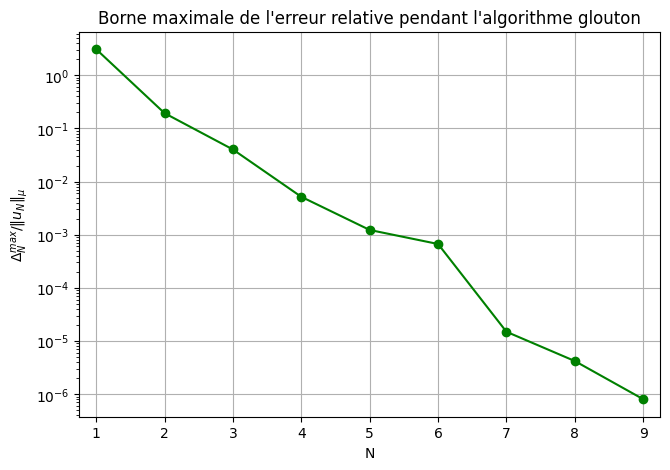

In [66]:
Ns = np.arange(1, Nmax+1)

fig, ax = plt.subplots(1, 1, figsize=(7.5, 5))
ax.semilogy(Ns, DeltaMax, 'go-')
ax.set_xlabel("N")
ax.set_xlim(0.75, Nmax+0.25)
ax.set_ylabel("$\Delta_N^{max}/\Vert u_N \Vert_{\mu}$")
ax.set_title("Borne maximale de l'erreur relative pendant l'algorithme glouton")
plt.grid();

Cela montre la convergence de la borne d'erreur relative au fur et à mesure de l'exécution de l'algorithme glouton. 

#### c) Comparaison entre la base RB de l'algorithme glouton et deux bases non hiérarchiques.

In [67]:
testSample = np.concatenate((np.linspace(0.1, 10, 50), np.logspace(-1, 1, 50)))
ntest = 100

In [68]:
def energyRelErr(u, un, Z, Ah):
    e = u - Z @ un
    return norm(e, Ah) / norm(u, Ah)

In [69]:
greedyErrs = np.empty((ntest, Nmax-1))
linErrs = np.empty((ntest, Nmax-1))
logErrs = np.empty((ntest, Nmax-1))

for i in range(ntest):
    mu = buildMu(testSample[i])
    Ah = assembleA(mu, Ahq)
    u = solve(mu, Ahq, Fh)

    for N in range(2, Nmax+1):
        linSample = np.linspace(0.1, 10, N)
        logSample = np.logspace(-1, 1, N)

        greedyZ = Z[:, :N]
        linZ = buildZ_(linSample, Ahq, Fh, AhqBar, N)
        logZ = buildZ_(logSample, Ahq, Fh, AhqBar, N)

        Anq, Fn, Ln = buildOff(greedyZ, Ahq, Fh)
        greedyun = solve(mu, Anq, Fn)
        Anq, Fn, Ln = buildOff(linZ, Ahq, Fh)
        linun = solve(mu, Anq, Fn)
        Anq, Fn, Ln = buildOff(logZ, Ahq, Fh)
        logun = solve(mu, Anq, Fn)

        greedyErrs[i, N-2] = energyRelErr(u, greedyun, greedyZ, Ah)
        linErrs[i, N-2] = energyRelErr(u, linun, linZ, Ah)
        logErrs[i, N-2] = energyRelErr(u, logun, logZ, Ah)

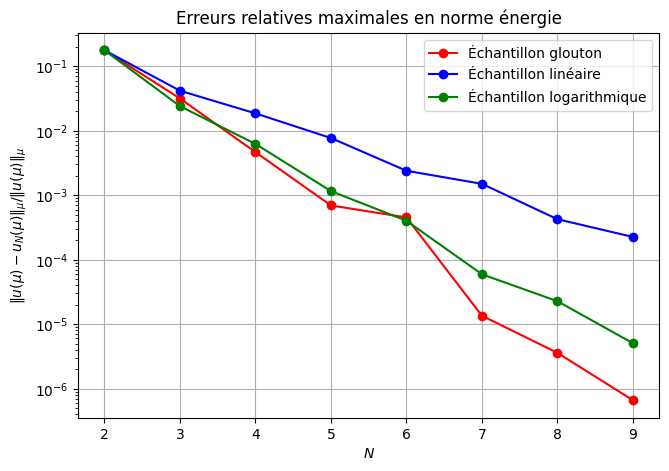

In [70]:
greedyData = np.max(greedyErrs, axis=0)
linData = np.max(linErrs, axis=0)
logData = np.max(logErrs, axis=0)
Ns = np.arange(2, Nmax+1)

fig, ax = plt.subplots(1, 1, figsize=(7.5, 5))
ax.semilogy(Ns, greedyData, 'ro-', label="Échantillon glouton")
ax.semilogy(Ns, linData, 'bo-', label="Échantillon linéaire")
ax.semilogy(Ns, logData, 'go-', label="Échantillon logarithmique")
ax.set_xlabel("$N$")
ax.set_ylabel("$\\Vert u(\mu)-u_N(\mu)\\Vert_{\\mu}/\\Vert u(\mu)\\Vert_{\\mu}$")
ax.set_title("Erreurs relatives maximales en norme énergie",)
ax.legend(loc="best")
plt.grid();

Comme nous pouvons le constater, l'échantillon obtenu à partir de l'algorithme glouton converge plus rapidement que les autres. Il est intéressant de voir que l'échantillon logarithmique donne des résultats acceptables, sans avoir besoin d'un quelconque algorithme. Nous pouvons même tester et montrer que l'échantillon logarithmique est aussi bon que celui de l'algorithme glouton entraîné sur un échantillon linéaire. L'échantillon linéaire est évidemment le pire.

### Q7. Algorithme glouton appliqué au cas II.

#### a) Quelle est la valeur de $N_{\mathrm{max}}$ pour obtenir la précision souhaitée ?

In [71]:
Nmax = 625
logks = np.logspace(-1, 1, 25)
logBis = np.logspace(-2, 0, 25)
trainSample = np.array([el for el in product(logks, logBis)])

C = spsolve(AhqBar, Fh)
CC = inner(C, C, AhqBar)
A = np.zeros((Qmax, NCal, Nmax))
CA = np.zeros((Qmax, Nmax))
AA = np.zeros((Qmax, Qmax, Nmax, Nmax))
muMin = buildMu(0.1, 0.01)

Z, greedySample, DeltaMax = greedySampling(Nmax, trainSample, Ahq, Fh, AhqBar, C, A, CC, CA, AA, muMin)

print("\nDimension de la matrice RB :", Z.shape)
print("Échantillon RB :\n", greedySample)

La borne d'erreur relative à l'étape 5 est : 0.49623923546672694
La borne d'erreur relative à l'étape 10 est : 0.07838024761248517
La borne d'erreur relative à l'étape 15 est : 0.009856579380256688
La borne d'erreur relative à l'étape 20 est : 0.0027022249712846534
La borne d'erreur relative à l'étape 25 est : 0.0006255253992364468
La borne d'erreur relative à l'étape 30 est : 0.00013772592590184104
La borne d'erreur relative à l'étape 35 est : 3.836729522762437e-05
La borne d'erreur relative à l'étape 40 est : 1.7686655359166064e-05
La borne d'erreur relative à l'étape 45 est : 5.38317388834585e-06
La borne d'erreur relative à l'étape 50 est : 1.4327678068693073e-06
La borne d'erreur relative à l'étape 53 est: 8.933936305072552e-07

Dimension de la matrice RB : (4760, 53)
Échantillon RB :
 [[ 0.1      0.01   ]
 [ 0.1      1.     ]
 [10.       0.01   ]
 ...
 [ 0.26102  1.     ]
 [ 0.14678  0.0261 ]
 [ 0.31623  0.68129]]


D'après les résultats la valeur de $N_{max}$ nécessaire pour la précision désirée est $53$.

#### b) Représentation de $\frac{\Delta_N^{max}}{\Vert u_N \Vert_{\mu}}$ en tant que fonction de $N$ 

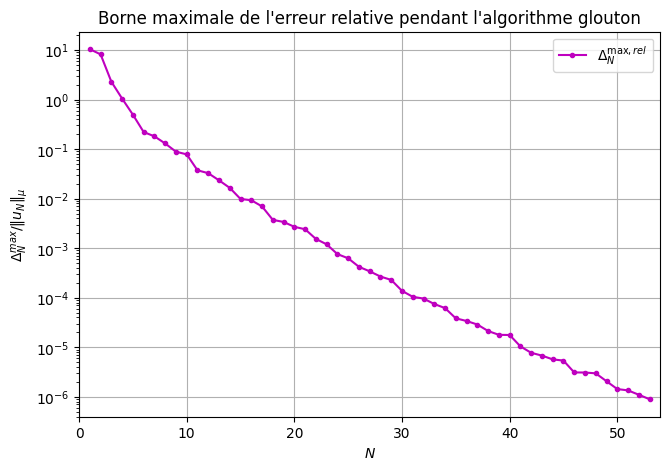

In [72]:
Nmax = len(DeltaMax)
Ns = np.arange(1, Nmax+1)

fig, ax = plt.subplots(1, 1, figsize=(7.5, 5))
ax.semilogy(Ns, np.array(DeltaMax), 'm.-', label="$\Delta_N^{\max, rel}$")
ax.set_xlabel("$N$")
ax.set_xlim(0, Nmax+1)
ax.set_ylabel("$\Delta_N^{max}/\Vert u_N \Vert_{\mu}$")
ax.set_title("Borne maximale de l'erreur relative pendant l'algorithme glouton")
ax.legend(loc="best")
plt.grid();

Cela montre la convergence de la borne d'erreur relative au fur et à mesure de l'exécution de l'algorithme glouton.

#### c) Tracé des échantillons gourmands SN

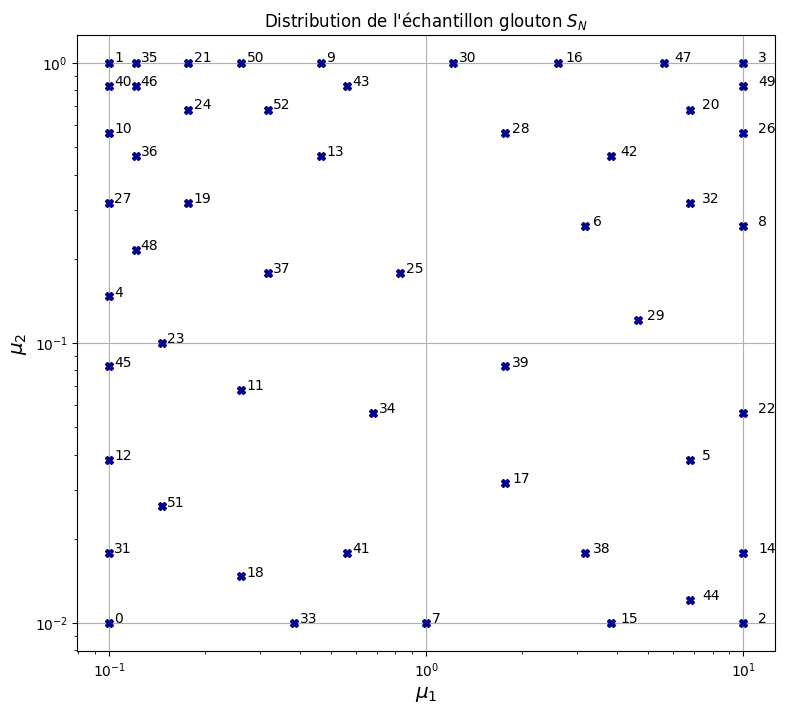

In [73]:
mus1 = np.empty(shape=(Nmax))
mus2 = np.empty(shape=(Nmax))
for N in range(Nmax):
    mus1[N], mus2[N] = greedySample[N]

fig, ax = plt.subplots(1, 1, figsize=(9, 8))
ax.loglog(mus1, mus2, "X", color="darkblue")
for N in range(Nmax):
    x, y = mus1[N], mus2[N]
    ax.annotate(str(N), xy=(x, y), xytext=(x+5, y), textcoords='offset pixels')
ax.set_xlabel("$\mu_1$", fontsize="x-large")
ax.set_ylabel("$\mu_2$", fontsize="x-large")
ax.set_title("Distribution de l'échantillon glouton $S_N$", fontsize="large")
plt.grid();

Les nombres dans la figure ci-dessus indiquent l'itération à laquelle le point représenté a été choisi (les 4 premiers points sont aux 4 coins de la surface). La distribution observée peut être attribuée au *principe du maximum*. D'un point de vue physique, les points sont distribués le long de la frontière du domaine, indiquant que l'erreur augmente près des bords.

#### d) Tracé de la convergence de l'erreur relative maximale dans la norme énergie et de l'erreur relative maximale en sortie.

In [74]:
links, logks = np.linspace(0.1, 10, 10), np.logspace(-1, 1, 10)
linBis, logBis = np.linspace(0.01, 1, 10), np.logspace(-2, 0, 10)
linXi = np.array([el for el in product(links, linBis)])
logXi = np.array([el for el in product(logks, logBis)])
testSample = np.concatenate((linXi, logXi))
ntest = 200

In [75]:
def outputRelErr(u, un, Lh, Ln):
    err = Lh @ u - Ln @ un
    outErr = np.abs(err)
    outNorm = np.abs(Ln @ un)
    return outErr / outNorm

In [76]:
enErrs = np.zeros((ntest, Nmax))
outErrs = np.zeros((ntest, Nmax))

for i in range(ntest):
    mu = buildMu(testSample[i, 0], testSample[i, 1])
    Ah = assembleA(mu, Ahq)
    u = solve(mu, Ahq, Fh)

    for N in range(Nmax):
        greedyZ = Z[:, :N+1]
        Anq, Fn, Ln = buildOff(greedyZ, Ahq, Fh)
        un = solve(mu, Anq, Fn)
        enErrs[i, N] = energyRelErr(u, un, greedyZ, Ah)
        outErrs[i, N] = outputRelErr(u, un, Fh, Ln)

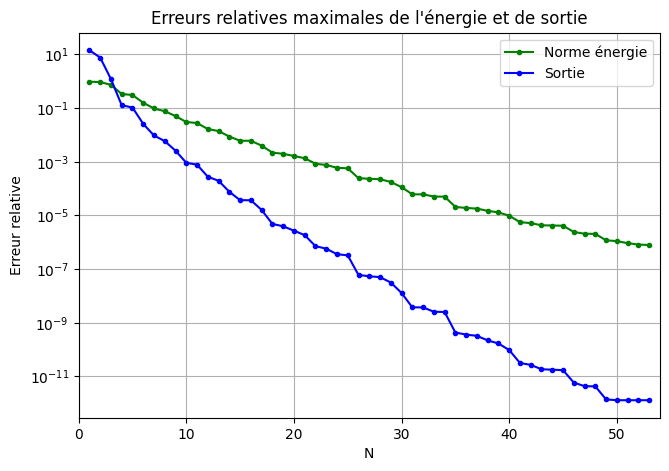

In [77]:
enErrMaxs = np.max(enErrs, axis=0)
outErrMaxs = np.max(outErrs, axis=0)

fig, ax = plt.subplots(1, 1, figsize=(7.5, 5))
ax.semilogy(Ns, enErrMaxs, 'g.-', label="Norme énergie")
ax.semilogy(Ns, outErrMaxs, 'b.-', label="Sortie")
ax.set_xlabel("N")
ax.set_xlim(0, Nmax+1)
ax.set_ylabel("Erreur relative")
ax.set_title("Erreurs relatives maximales de l'énergie et de sortie")
ax.legend(loc="best")
plt.grid();

Nous pouvons voir que l'erreur de sortie converge de manière quadratique par rapport à l'erreur de la norme énergie, comme le prédit la théorie : 
$$\boxed{\Delta^s_N(\mu) = \Delta^{en}_N(\mu)^2}$$